In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split




def read_imdb_data_csv(csv_path='IMDB Dataset.csv', test_size=0.2, random_state=42):
    """
    Read IMDb reviews from a single CSV with columns: 'review', 'sentiment'.
    Returns nested dicts to match the original folder-based API:
      data['train']['pos'], data['train']['neg'], data['test']['pos'], data['test']['neg']
      labels['train']['pos'], ... (each is a parallel list of labels)
    """
    # 1) Load CSV
    df = pd.read_csv(csv_path)

    # Basic validation
    required_cols = {'review', 'sentiment'}

    # 2) Normalize labels to exactly 'pos'/'neg' for consistency with your old code
    df = df.copy()
    df['sentiment'] = df['sentiment'].str.lower().map({'positive': 'pos', 'negative': 'neg'})

    # 3) Train/test split (stratified to preserve class balance)
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df['sentiment']
    )

    # 4) Build nested dicts
    data = {'train': {'pos': [], 'neg': []}, 'test': {'pos': [], 'neg': []}}
    labels = {'train': {'pos': [], 'neg': []}, 'test': {'pos': [], 'neg': []}}
    splits = {'train': train_df, 'test': test_df}

    data = {
     sn: {sk: sdf.loc[sdf['sentiment'].eq(sk), 'review'].tolist() for sk in ('pos','neg')}
     for sn, sdf in splits.items()
     }


    labels = {
      sn: {sk: [sk]*len(data[sn][sk]) for sk in ('pos','neg')}
      for sn in data
}


    return data, labels


# ==== Example usage (mirrors your print) ====
data, labels = read_imdb_data_csv()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
    len(data['train']['pos']), len(data['train']['neg']),
    len(data['test']['pos']), len(data['test']['neg'])
))


IMDb reviews: train = 20000 pos / 20000 neg, test = 5000 pos / 5000 neg


In [5]:
print(data['train']['pos'][0])

I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed "Princess Laia" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see "Chewabacca" played by what looks like a Muppet! It was extremely silly and stupid...but I couldn't stop laughing. Most of the dialogue was drowned out because of all the laughter. Also if you know "Star Wars" pretty well it's even funnier--they deliberately poke fun at some of the dialogue. This REALLY works with an audience! A definite 10!


In [6]:
print(data['train']['neg'][2])

If there's one thing I've learnt from watching George Romero's Creepshow, it's that if you stumble upon an mysterious old crate that someone has obviously gone to a lot of effort to hide, just leave well alone: there's probably something nasty inside.<br /><br />Obviously, Professor Gordon Crowley, Robert Englund's character in 'Jack Brooks, Monster Slayer' isn't a Romero fan, 'cos he busts open the old wooden box he finds buried in his yard, only to discoversurprise, surprisean ancient demon that possesses his body (initially causing him to eat and vomit rather a lot).<br /><br />When the demon eventually erupts from Crowley's body during chemistry class and begins to transform the students into hellish, flesh-tearing beasts, it's up to plumber Jack Brooks (Trevor Matthews) to try and stop the foul creatures, armed only with a length of pipe and fuelled by a lifelong hatred of all things monstrous!.<br /><br />The DVD packaging for Jon Knautz's low-budget monster flick promises one 

In [7]:
!pip install wordcloud

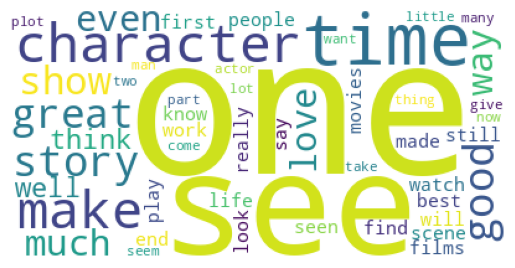

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

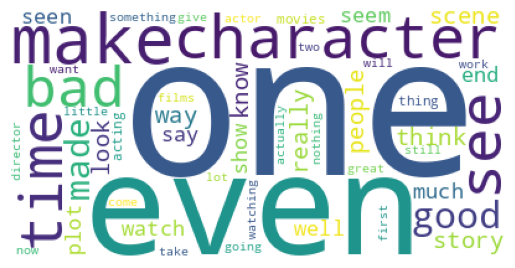

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

In [10]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, pos_label=1, neg_label=0, random_state=42):
    """Combine pos/neg into unified lists and shuffle them."""

    # 1) Combine texts
    data_train = data['train']['pos'] + data['train']['neg']
    data_test  = data['test']['pos']  + data['test']['neg']

    # 2) Build numeric labels (pos=1, neg=0)
    labels_train = [pos_label]*len(data['train']['pos']) + [neg_label]*len(data['train']['neg'])
    labels_test  = [pos_label]*len(data['test']['pos'])  + [neg_label]*len(data['test']['neg'])

    # 3) Shuffle (texts & labels stay aligned)
    data_train, labels_train = shuffle(data_train, labels_train, random_state=random_state)
    data_test,  labels_test  = shuffle(data_test,  labels_test,  random_state=random_state)

    return data_train, data_test, labels_train, labels_test

# Example usage
data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))


IMDb reviews (combined): train = 40000, test = 10000


In [11]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import re

# NLTK helpers (auto-download stopwords if missing)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
try:
    _ = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()

def review_to_words(review: str):
    """Convert a raw review string into a list of cleaned, stemmed words."""
    # 1) Remove HTML tags
    text = re.sub(r"<.*?>", " ", str(review))

    # 2) Normalize common negations (optional but useful)
    text = re.sub(r"n['’]t\b", " not", text, flags=re.IGNORECASE)

    # 3) Keep letters & apostrophes; lowercase
    text = re.sub(r"[^a-zA-Z']", " ", text).lower()

    # 4) Tokenize (simple split is fine here)
    tokens = text.split()

    # 5) Remove stopwords & very short tokens, then stem
    words = [STEMMER.stem(t) for t in tokens if t not in STOPWORDS and len(t) > 1]

    return words

# Quick test
print(review_to_words("""This is just a <em>test</em>.<br/><br/>
But if it wasn't a test, it would make for a <b>Great</b> movie review!"""))


['test', 'test', 'would', 'make', 'great', 'movi', 'review']


In [13]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay

    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))

        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])

    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
I am a big fan of Lonesome Dove and all the books in the series and I love the movie. I was happy to see that they finished up with Comanche moon. I have been a long time fan of Steve Zahn and was eager to see him in a serious role. I personally think that Steve Zahn has done an amazing job of re-creating Gus. I can't think of another actor who would have been better. He has the voice, the mannerisms, the pronunciation of word all down to a T. Granted, no one could ever hold a candle to Robert Duvall as Gus, but I think that Steve Zahn has done a pretty darn good job. Karl Urban acts the same in all the movies he has been in so he has made a good match for Woodrow Call. AS for the movie itself, yeah it's a little corny but can you really beat Lonesome Dove? No, I don't think so.

--- Preprocessed words ---
['big', 'fan', 'lonesom', 'dove', 'book', 'seri', 'love', 'movi', 'happi', 'see', 'finish', 'comanch

In [14]:
import os
import random
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib  # ✅ use standalone joblib

def extract_BoW_features(
    words_train,
    words_test,
    vocabulary_size=5000,
    cache_dir="cache_bow",              # ✅ define a default cache dir
    cache_file="bow_features.pkl"
):
    """Extract Bag-of-Words features for preprocessed token lists OR raw strings."""
    os.makedirs(cache_dir, exist_ok=True)
    cache_path = os.path.join(cache_dir, cache_file) if cache_file else None

    # Try cache
    cache_data = None
    if cache_path and os.path.exists(cache_path):
        try:
            cache_data = joblib.load(cache_path)
            print("Read features from cache file:", cache_path)
        except Exception:
            cache_data = None  # ignore cache read errors

    if cache_data is None:
        # Auto-detect input type
        first_item = words_train[0] if len(words_train) else ""
        is_tokenized = isinstance(first_item, (list, tuple))

        if is_tokenized:
            # ✅ Inputs are already tokenized: use identity tokenizer & disable regex
            vectorizer = CountVectorizer(
                max_features=vocabulary_size,
                analyzer="word",
                preprocessor=lambda x: x,
                tokenizer=lambda x: x,
                token_pattern=None,   # must disable default regex
                lowercase=False       # tokens already in desired case
            )
        else:
            # ✅ Inputs are raw strings: let CountVectorizer tokenize
            vectorizer = CountVectorizer(
                max_features=vocabulary_size
            )

        Xtr = vectorizer.fit_transform(words_train)
        Xte = vectorizer.transform(words_test)

        # Dense arrays for easy inspection (use Xtr/Xte directly if memory is a concern)
        features_train = Xtr.toarray()
        features_test  = Xte.toarray()
        vocabulary     = vectorizer.vocabulary_

        if cache_path:
            joblib.dump(
                dict(features_train=features_train,
                     features_test=features_test,
                     vocabulary=vocabulary),
                cache_path
            )
            print("Wrote features to cache file:", cache_path)
    else:
        features_train = cache_data["features_train"]
        features_test  = cache_data["features_test"]
        vocabulary     = cache_data["vocabulary"]

    return features_train, features_test, vocabulary

# ==== Usage (unchanged) ====
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

print("Vocabulary: {} words".format(len(vocabulary)))
print("Sample words:", random.sample(list(vocabulary.keys()), min(8, len(vocabulary))))

print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])


Read features from cache file: cache_bow/bow_features.pkl
Vocabulary: 5000 words
Sample words: ['liberti', 'rate', 'axe', 'colonel', 'price', 'confin', 'wherea', 'celebr']

--- Preprocessed words ---
['appal', 'bad', 'film', 'pastich', 'earli', 'th', 'centuri', 'hollywood', 'artist', 'set', 'new', 'low', 'even', 'past', 'modern', 'gasp', 'cradl', 'rock', 'never', 'thought', 'see', 'film', 'wors', 'grant', 'slightli', 'differ', 'milieu', 'period', 'nevertheless', 'intent', 'result', 'distressingli', 'similar', 'first', "there'", 'horribl', 'cast', 'eddi', 'izzard', 'chaplin', 'excus', 'peter', 'owe', 'guy', 'someth', 'jennif', 'tilli', 'loulla', 'parson', 'kirsten', 'dunst', 'marion', 'davi', 'holi', 'smoke', 'peopl', 'even', 'begin', 'tri', 'captur', 'look', 'sound', 'period', 'purportedli', 'depict', 'well', 'last', 'pictur', 'show', 'decent', 'film', 'thing', 'disast', 'rest', "bogdonovitch'", 'pic', 'much', 'better', 'guess', 'rub', 'well', 'hitch', 'ford', 'wore', 'long', 'time', '

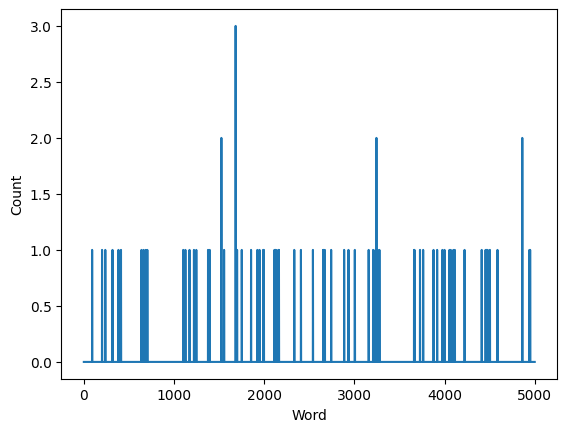

In [15]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

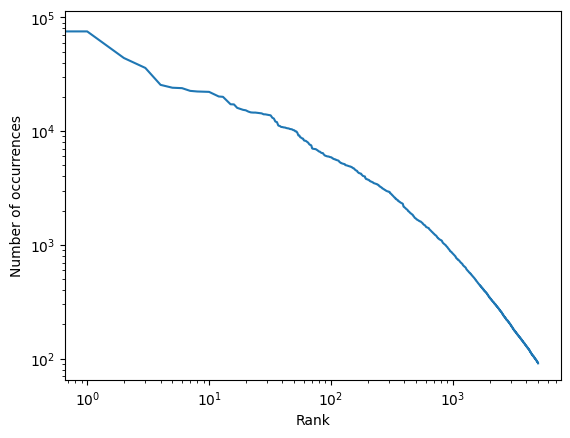

In [16]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [17]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

In [18]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.81035, test = 0.7807


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)

    # TODO(optional): Perform hyperparameter tuning / model selection

    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))

    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.7922, test = 0.7929


In [20]:
# TODO: Write a sample review and set its true sentiment
my_review = "I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end."
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
my_bow_features = vectorizer.transform([my_words]).toarray()  # pass an array of 1 element

# TODO: Then call your classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))

--- My review ---
I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end.

--- Preprocessed words ---
['thought', 'would', 'like', 'bore', 'sequel', 'come', 'everyday', 'gone', "would'v", 'miss', 'treat', 'bore', 'kept', 'edg', 'seat', 'till', 'end']

True sentiment: pos, predicted sentiment: 0


In [21]:
from keras.datasets import imdb  # import the built-in imdb dataset in Keras

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data (note the difference in convention compared to scikit-learn)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded dataset with 25000 training samples, 25000 test samples


In [22]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

In [23]:
# Map word IDs back to words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'you', 'deals', 

In [1]:
from keras.preprocessing import sequence

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# TODO: Pad sequences in X_train and X_test
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

NameError: name 'X_train' is not defined

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# TODO: Design your model
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

In [26]:
# TODO: Compile your model, specifying a loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# TODO: Specify training parameters: batch size and number of epochs
batch_size = 64
num_epochs = 3

# TODO(optional): Reserve/specify some training data for validation (not to be used for training)
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

# TODO: Train your model
model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
390/390 ━━━━━━━━━━━━━━━━━━━━ 304s 773ms/step - accuracy: 0.6768 - loss: 0.5724 - val_accuracy: 0.9531 - val_loss: 0.1703
Epoch 2/3
 30/390 ━━━━━━━━━━━━━━━━━━━━ 5:08 856ms/step - accuracy: 0.8557 - loss: 0.3523

KeyboardInterrupt: 

In [ ]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

In [ ]:
# Evaluate your model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']